# Вычисление мультифрактального спектра с помощью функции плотности.

__Мультифрактальный спектр цифрового изображения__ - множество фрактальных размерностей его фрактальных подмножеств.

- $\mu$ обозначает меру интенсивностей пикселей.
- Для каждого $x \in R^2$ обозначим за $B(x,r)$ квадрат с центром $x$ и “радиусом” (половиной длины стороны) $r$.
- Функция плотности определяется следующим образом: $d(x)=\underset{r \rightarrow 0}{lim}\frac{log \mu (B(x, r))}{log r}$ (Считается для каждой точки)

In [50]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from scipy.ndimage.filters import convolve, median_filter, maximum_filter
from scipy.stats import linregress
from progressbar import ProgressBar

In [2]:
im = Image.open('data/silver/large.jpg')

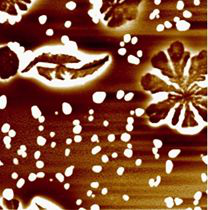

In [3]:
im

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [1/3, 1/3, 1/3])

In [8]:
immat = rgb2gray(np.array(im))

In [37]:
rs = range(2, 10)
dxs = []
for r in rs:
    dx = convolve(immat, np.ones((r*2, r*2)), mode='constant')
    dxs.append(dx.ravel())

Предел вычисляем с помощью МНК

In [41]:
frac_dims = []
bar = ProgressBar()
for l in bar(np.array(dxs).T):
    frac_dims.append(linregress(np.log(rs), np.log(l)).slope)

100% (43680 of 43680) |##################| Elapsed Time: 0:00:20 Time:  0:00:20


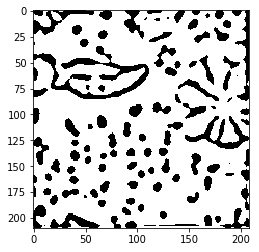

In [53]:
plt.imshow(np.array(frac_dims).reshape(immat.shape) >= np.mean(frac_dims)-0.3, cmap='gray')

Затем, получив все $d(x)$, считаем фрактульную размерность для изображений для различных $\alpha$ следующим образом:

$d(x)$ характеризует степень неоднородности распределения интенсивности в окрестности точки $x$. Множество всех точек $x$, имеющих локальную плотность $\alpha$, образует множество уровня $E_{\alpha}=\{x \in R^2: d(x)=\alpha \}$. На практике часто для того, чтобы не увеличивать количество множеств уровня, рассматривают множества $E(\alpha, \epsilon)=\{x \in R^2: d(x)\in [\alpha, \alpha + \epsilon)\}$.

Далее мы вычисляем фрактальные размерности множеств $E_{\alpha}$ и получаем фрактальный спектр $f(\alpha)$.

In [56]:
def frac_dim(immat):    
    # Задаем размер квадрата, которым будем ходить по изображению
    ws = range(1, 10)
    # К-во квадратов, куда попал черный пиксель
    ns = []
    for w in ws:
        ns.append(np.sum(maximum_filter(immat, (w, w), mode='constant')[::w, ::w]))
        
    x = np.log(1/np.array(ws))
    y = np.log(ns)
    
    slope = linregress(x, y).slope
    
    return slope

In [88]:
frac_spec = []
alphas = np.linspace(np.min(frac_dims), np.max(frac_dims), num=15)
for a0, a1 in zip(alphas[:-1], alphas[1:]):
    frac_im = np.array(frac_dims).reshape(immat.shape)
    frac_im = (frac_im > a0) & (frac_im < a1)
    frac_spec.append(frac_dim(frac_im))

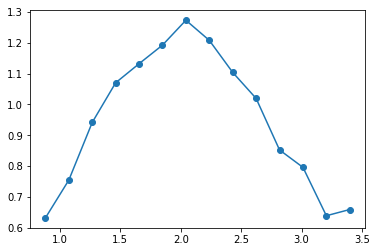

In [89]:
plt.plot(alphas[:-1], frac_spec, '-o')